### Preparing Data&Model

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch_geometric_temporal import ASTGCN
from torch_geometric.utils import dense_to_sparse
from torch.amp import GradScaler, autocast
from tqdm.auto import tqdm
from model.model_core_architecture import ASTGCN_V2

# your existing utils
from utils.concatenate_data import run_pipeline
from utils.build_station_weight import build_station_weights
locations = {
    "Data_สถานีชาร์จ": (13.736418765099916, 100.52524210026607), # Corrected coordinates is 13.736418765099916, 100.52524210026607
    "Data_อาคารจามจุรี4": (13.738963239687536, 100.52843073814955), # Corrected coordinates is 13.738963239687536, 100.52843073814955
    "Data_อาคารจามจุรี 9": (13.735899096644642, 100.52550388047727), # Corrected coordinates is 13.735899096644642, 100.52550388047727
    "Data_อาคารจุลจักรพงษ์": (13.73558133067766, 100.5309154651327), # Corrected coordinates is 13.73558133067766, 100.5309154651327
    "Data_อาคารบรมราชกุมารี": (13.739340161417255, 100.53355852280504), # Corrected coordinates is 13.739340161417255, 100.53355852280504
    # "Data_อาคารวิทยนิเวศน์": (13.740842756926996, 100.5269634228051), # Corrected coordinates is 13.740842756926996, 100.5269634228051
}
# 1. Load & preprocess
all_data_df, long_df = run_pipeline(
    root_xlsx_dir="Load-data",
    cleaned_csv_dir="cleaned_data",
    preprocessed_csv_dir="preprocessed_data",
    final_wide_csv="all_data_df.csv",
    final_long_csv="all_data_timeseries.csv",
)
long_df.loc[long_df['Electricity(kW)'] < 0, 'Electricity(kW)'] = 0
long_df = long_df[long_df['station_name']!= 'Data_อาคารวิทยนิเวศน์']   

station_weights_df = build_station_weights(long_df)
print("Station weights:\n", station_weights_df)

# 2. Three-way split per station (70% train / 10% eval / 20% test)
def split_threeway(df, train_frac=0.7, eval_frac=0.1):
    train_list, eval_list, test_list = [], [], []
    for station, sdf in df.groupby('station_name'):
        sdf = sdf.sort_values('Date')
        n = len(sdf)
        n_train = int(n * train_frac)
        n_eval  = int(n * (train_frac + eval_frac)) - n_train
        train_list.append(sdf.iloc[:n_train])
        eval_list.append (sdf.iloc[n_train:n_train + n_eval])
        test_list.append (sdf.iloc[n_train + n_eval:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    eval_df  = pd.concat(eval_list).reset_index(drop=True)
    test_df  = pd.concat(test_list).reset_index(drop=True)
    return train_df, eval_df, test_df

train_df, eval_df, test_df = split_threeway(long_df, train_frac=0.7, eval_frac=0.1)
print(f"Rows → train: {len(train_df)}, eval: {len(eval_df)}, test: {len(test_df)}")

# 3. Graph structure (fully connected)
station_names = sorted(long_df['station_name'].unique())
station_weights_df = build_station_weights(long_df)
station_weights_dict = station_weights_df.set_index("station_name")["normalized_reverse_weight"].to_dict()
num_nodes     = len(station_names)
edge_index    = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long
).t().contiguous()

# 4. Build sliding‐window tensors
def pivot_to_tensor(df, seq_len, station_names):
    pv = df.pivot(index='Date', columns='station_name', values='Electricity(kW)')
    pv = pv[station_names].fillna(0.0)
    arr = []
    for i in range(len(pv) - seq_len + 1):
        w = pv.iloc[i : i + seq_len].values  # (seq_len, N)
        arr.append(w.T)                     # (N, seq_len)
    return torch.tensor(np.stack(arr, axis=0), dtype=torch.float)

len_input = 96
pred_len  = 96

arr_tr = pivot_to_tensor(train_df, len_input + pred_len, station_names)
X_tr, Y_tr = arr_tr[:, :, :len_input], arr_tr[:, :, len_input:]
arr_ev = pivot_to_tensor(eval_df,  len_input + pred_len, station_names)
X_ev, Y_ev = arr_ev[:, :, :len_input], arr_ev[:, :, len_input:]
arr_te = pivot_to_tensor(test_df, len_input + pred_len, station_names)
X_te, Y_te = arr_te[:, :, :len_input], arr_te[:, :, len_input:]

# 5. Dataset & DataLoaders
class TemporalDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

batch_size = 512
train_loader = DataLoader(TemporalDataset(X_tr, Y_tr), batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(TemporalDataset(X_ev, Y_ev), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TemporalDataset(X_te, Y_te), batch_size=batch_size, shuffle=False)

# 6. ASTGCN with adaptive adjacency



config = {
    "nb_block": 2,
    "in_channels": 1,
    "K": 2,
    "nb_chev_filter": 64,
    "nb_time_filter": 64,
    "time_strides": 1,
    "num_for_predict": pred_len,
    "len_input": len_input,
    "num_of_vertices": num_nodes,
    "normalization": "sym",
    "bias": True,
}


Station weights:
              station_name  normalized_reverse_weight
0         Data_สถานีชาร์จ                   1.000000
1     Data_อาคารจามจุรี 9                   1.000000
2   Data_อาคารจุลจักรพงษ์                   1.002786
3  Data_อาคารบรมราชกุมารี                   1.002786
4      Data_อาคารจามจุรี4                   1.094225
Rows → train: 118740, eval: 16963, test: 33929


### Plot Attention Matrix

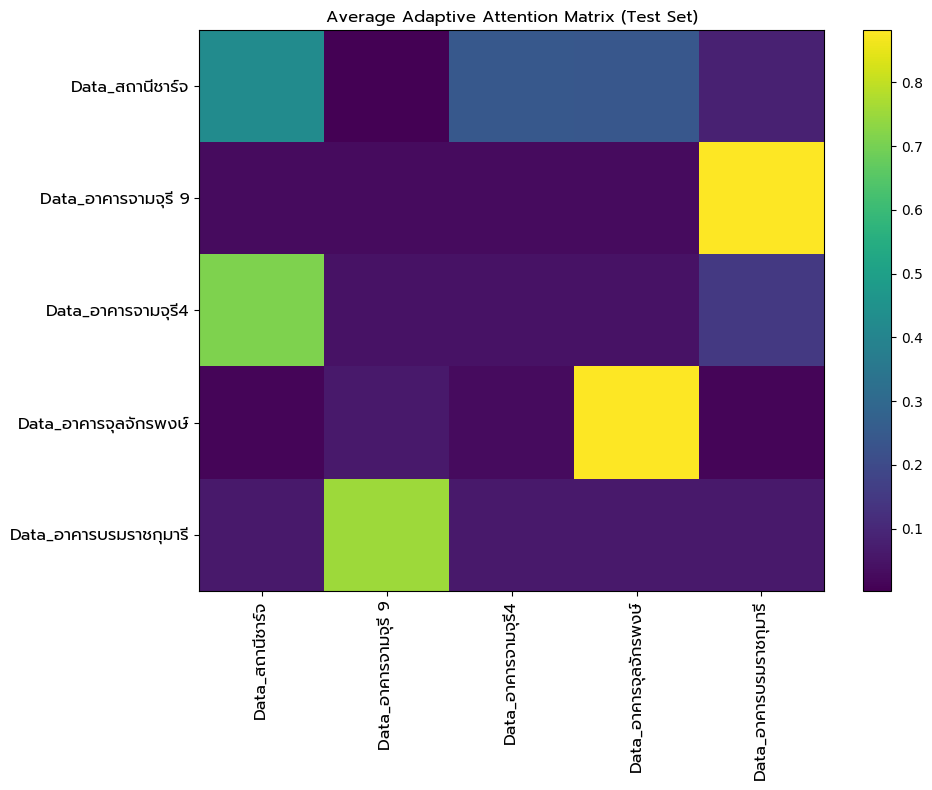

In [12]:
from model.attention import plot_test_attention_heatmap
# assuming you have:
#   ASTGCN_V2 class, config dict, station_names list, test_loader, and font file
fig, mean_attention = plot_test_attention_heatmap(
    model_class=ASTGCN_V2,
    config=config,
    station_names=['Data_สถานีชาร์จ',
 'Data_อาคารจามจุรี 9',
 'Data_อาคารจามจุรี4',
 'Data_อาคารจุลจักรพงษ์',
 'Data_อาคารบรมราชกุมารี'],
    test_loader=test_loader,
    checkpoint_path="best_model.pt",
    font_path="Prompt_Font/Prompt-Regular.ttf"
)


### Plot Attention coordinate Graph

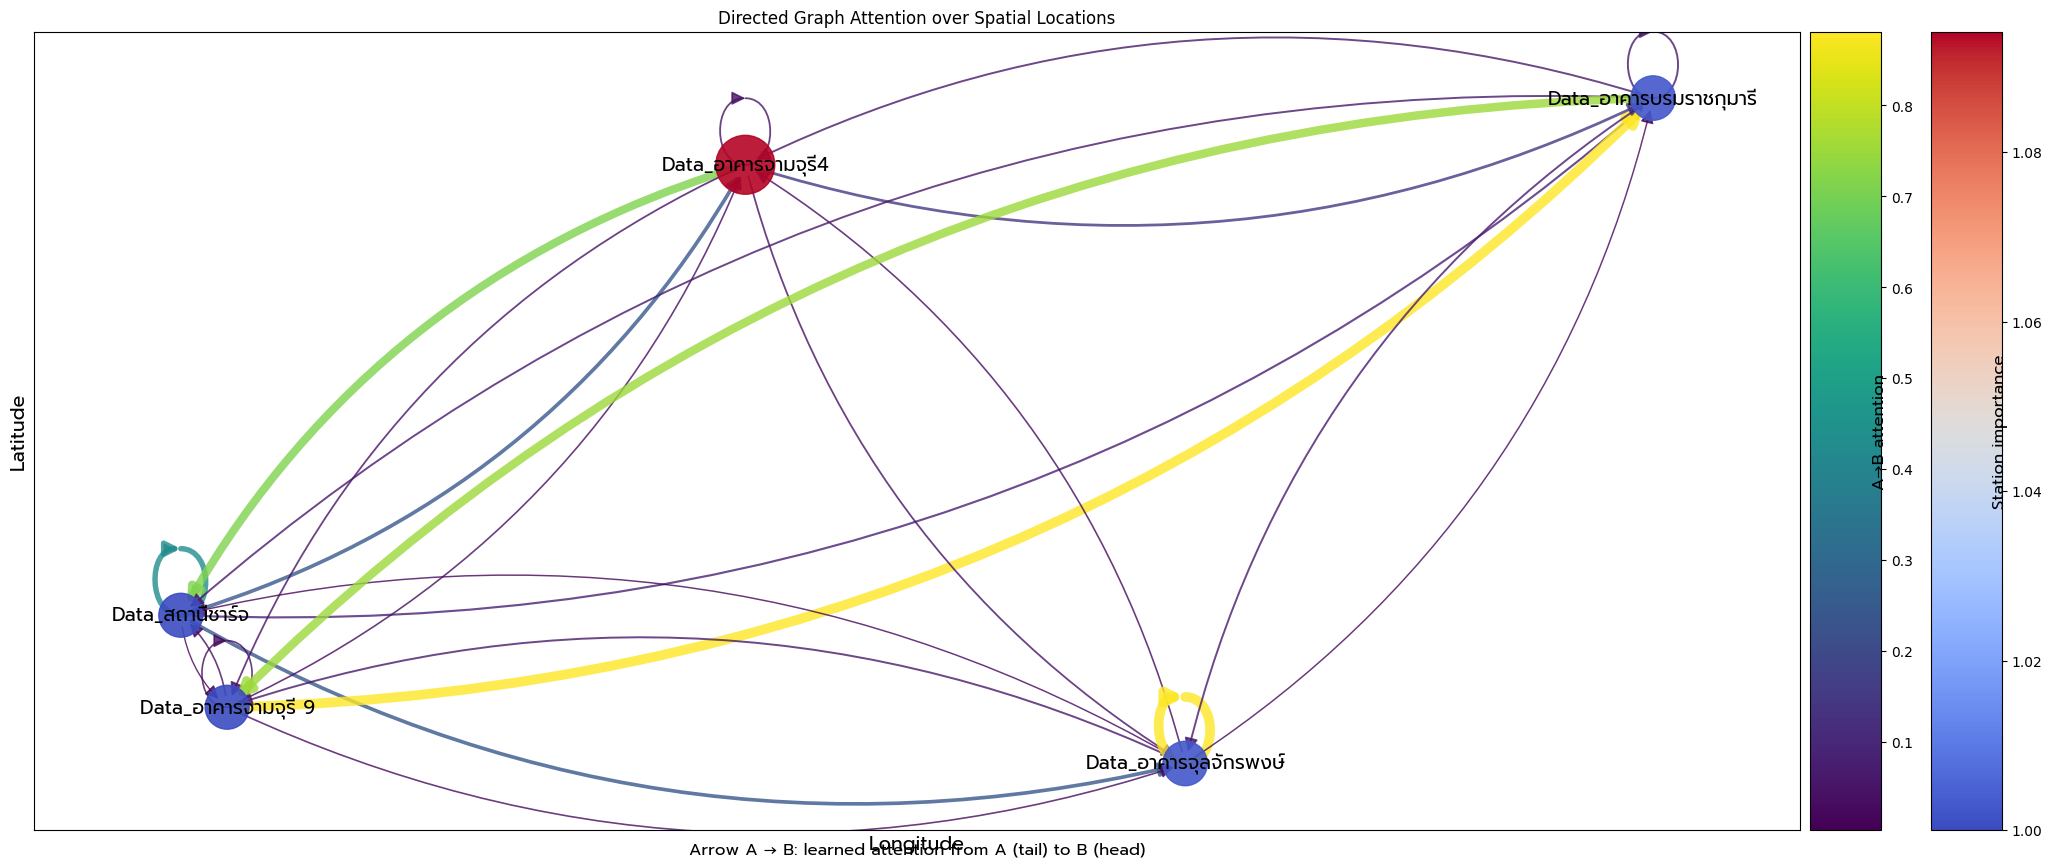

In [14]:
from model.attention import plot_spatial_attention_graph

# Example usage:
fig = plot_spatial_attention_graph(
    mean_attention=mean_attention,
    station_names=station_names,
    locations=locations,
    station_weights=station_weights_dict,
    font_path="Prompt_Font/Prompt-Regular.ttf",
    threshold_percentile=0
)
